In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy import stats
import statsmodels.api as sm
from itertools import product
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

In [2]:
BTC_Ticker = yf.Ticker("BTC-USD")
BTC_Data = BTC_Ticker.history(period="max", )

In [3]:
BTC_Data.index = pd.to_datetime(BTC_Data.index)

In [4]:
BTC_Data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,0.0,0.0
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,0.0,0.0
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,0.0,0.0
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,0.0,0.0
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,0.0,0.0
...,...,...,...,...,...,...,...
2023-10-09 00:00:00+00:00,27934.472656,27989.470703,27302.562500,27583.677734,12007668568,0.0,0.0
2023-10-10 00:00:00+00:00,27589.201172,27715.847656,27301.654297,27391.019531,9973350678,0.0,0.0
2023-10-11 00:00:00+00:00,27392.076172,27474.115234,26561.099609,26873.320312,13648094333,0.0,0.0


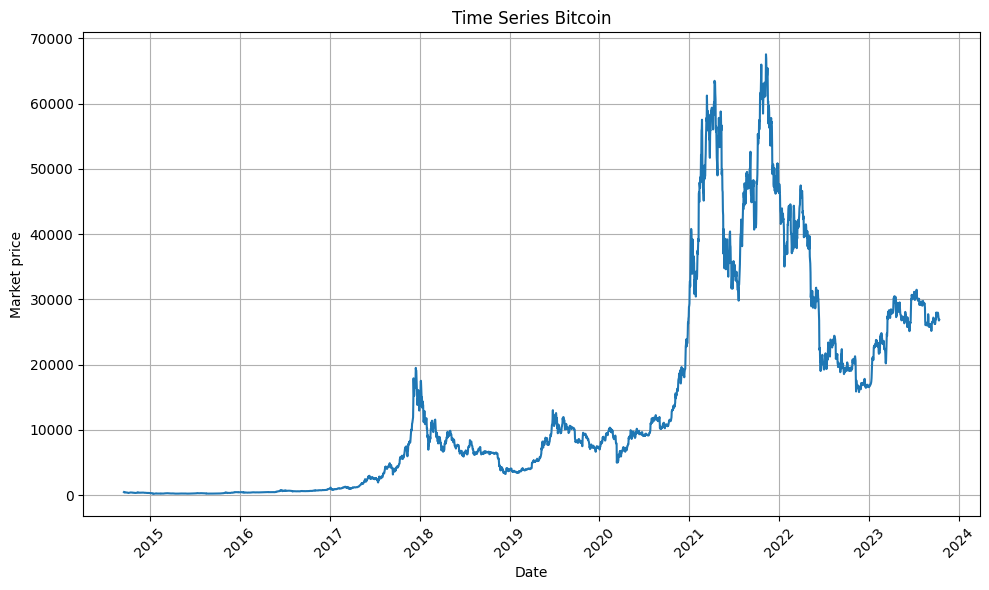

In [5]:
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(BTC_Data.index, BTC_Data['Close'], linestyle='-')  # Create the line plot
plt.title('Time Series Bitcoin')  # Set the title
plt.xlabel('Date')  # Set the x-axis label
plt.ylabel('Market price')  # Set the y-axis label
plt.grid(True)  # Show grid lines
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Show the plot
plt.show()

### Preliminary Analysis of the Bitcoin time-series

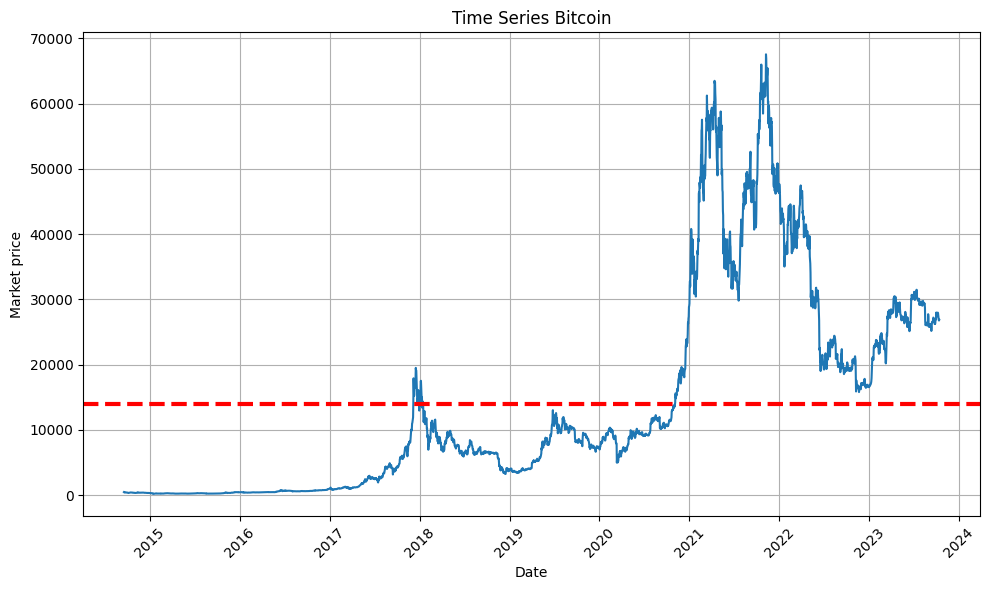

In [6]:
# create a time series plot with a mean line
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(BTC_Data.index, BTC_Data['Close'], linestyle='-')  # Create the line plot
plt.axhline(y=np.nanmean(BTC_Data['Close']), color='red', linestyle='--', linewidth=3, label='Avg')
plt.title('Time Series Bitcoin')  # Set the title
plt.xlabel('Date')  # Set the x-axis label
plt.ylabel('Market price')  # Set the y-axis label
plt.grid(True)  # Show grid lines
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Show the plot
plt.show()

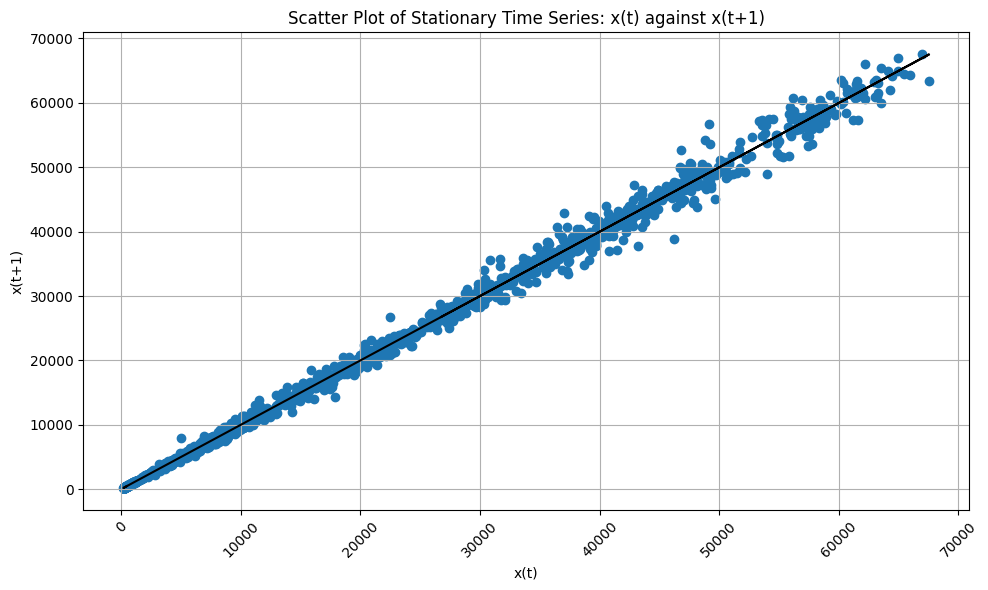

In [7]:
# make regression line between x(t) and x(t+1)
lr = LinearRegression()
lr.fit(np.array(BTC_Data['Close'][:-1]).reshape(-1,1), BTC_Data['Close'][1:])
y_pred = lr.predict(np.array(BTC_Data['Close'][:-1]).reshape(-1,1))

# scatter plot between x(t) and x(t+1)
plt.figure(figsize=(10, 6))  # Set the figure size
plt.scatter(BTC_Data['Close'][1:], BTC_Data['Close'][:-1])  # Create the scatter plot
plt.plot(BTC_Data['Close'][:-1], y_pred, color='k') #LinearRegression plot
plt.title('Scatter Plot of Stationary Time Series: x(t) against x(t+1)')  # Set the title
plt.xlabel('x(t)')  # Set the x-axis label
plt.ylabel('x(t+1)')  # Set the y-axis label
plt.grid(True)  # Show grid lines
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels 

# Show the plot
plt.show()

### shows positive correlation

#### Addressing the Seasonality, Trends of TS

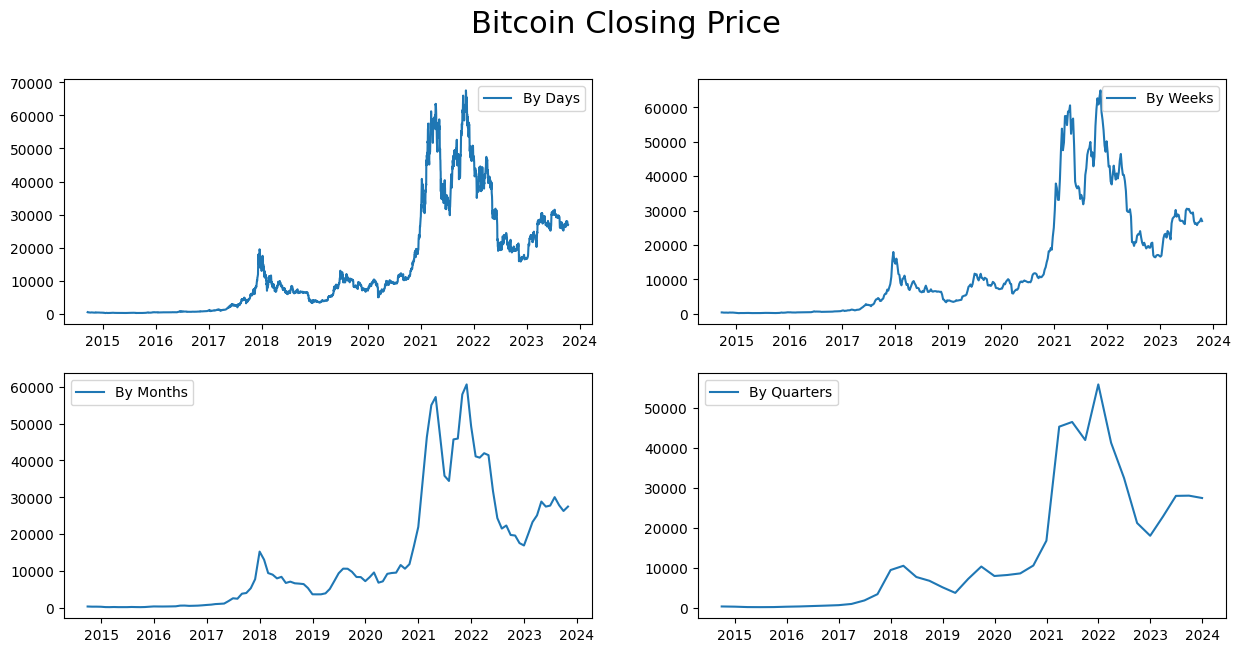

In [8]:
df = BTC_Data
# resampling to daily, monthly, annual and quarterly frequency
df = df.resample('D').mean()
df_month = df.resample('M').mean()
df_year = df.resample('A-DEC').mean()
df_Q = df.resample('Q-DEC').mean()
df_week = df.resample('W-MON').mean()

# PLOTS
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin Closing Price', fontsize=22)

plt.subplot(221)
plt.plot(df.Close, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_week.Close, '-', label='By Weeks')
plt.legend()

plt.subplot(223)
plt.plot(df_month.Close, '-', label='By Months')
plt.legend()

plt.subplot(224)
plt.plot(df_Q.Close, '-', label='By Quarters')
plt.legend()

# plt.subplot(224)
# plt.plot(df_year.Close, '-', label='By Years')
# plt.legend()

# plt.tight_layout()
plt.show()

#### Stationarity check and STL-decomposition of the series

Is the model an additive or multiplicative model? How to interpret this?

Dickey–Fuller test: p=0.507744


<Figure size 1500x700 with 0 Axes>

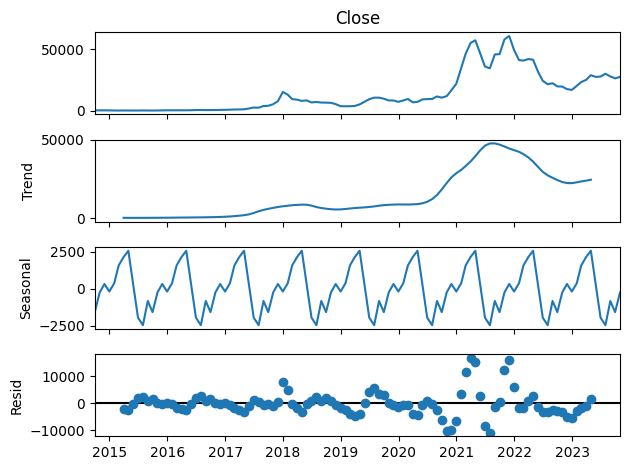

In [9]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_month.Close, model="additive").plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Close)[1])
plt.show()

Taking into account the trends and seasonal behaviour, the series does not look stationary as the values depend upon the timeframe. In terms of residuals, this also does not looks stationary (looks like it has a pattern and is not random in my opinion). Thus, overall, this is a non stationary timeseries.

Dickey–Fuller test: p=0.507744


<Figure size 1500x700 with 0 Axes>

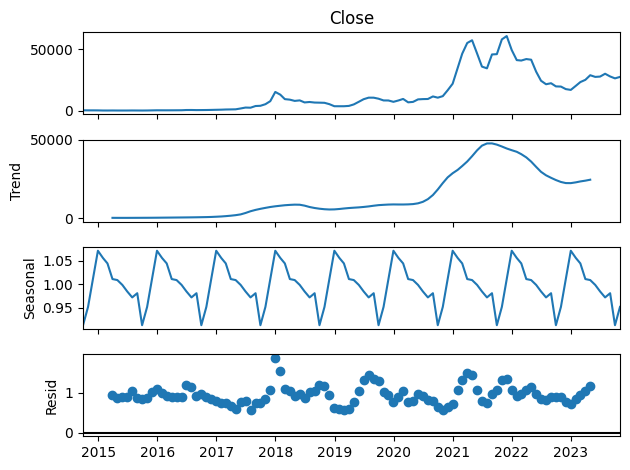

In [10]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_month.Close, model="multiplicative").plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Close)[1])
plt.show()

For the multiplicative model, the residuals look random, thus, (in my opinion), it can be considered stationary

Overall: The presence of trend and seasonal component in the Time Series makes it non-stationary and thus, differencing would be required to make it stationary. The presence of seasonality also means we can use the Seasonality based models (eg. SARIMA).

Dickey–Fuller test: p=0.580902


<Figure size 1500x700 with 0 Axes>

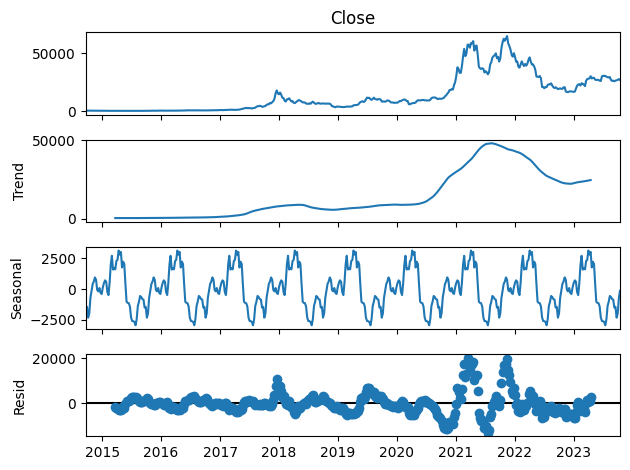

In [11]:
# predicting by weeks
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_week.Close, model="additive").plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_week.Close)[1])
plt.show()

We notice yearly seasonality here.

Dickey–Fuller test: p=0.580902


<Figure size 1500x700 with 0 Axes>

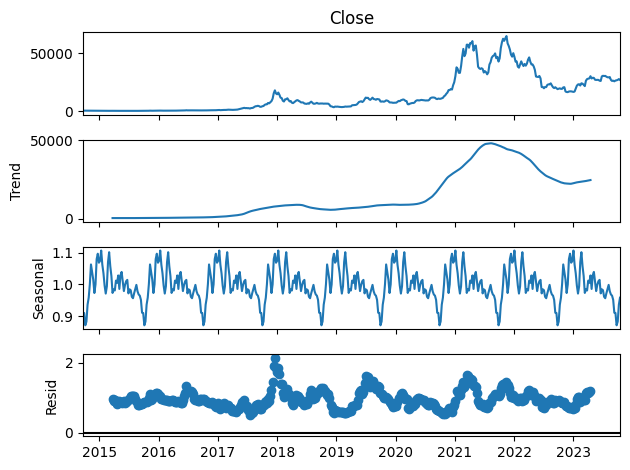

In [12]:
# predicting by weeks
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_week.Close, model="multiplicative").plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_week.Close)[1])
plt.show()

#### Transformations

p-value needs to be as little as possible, preferably alpha<0.05, for stationarity

On a time series plot, the analyst sees that the difference between the high and low seasonal peaks grows over time. This pattern indicates that the variance is not stationary. The analyst performs a Box-Cox transformation to make the variance stationary before the analyst fits the ARIMA model. - in the current case, variance increases and decreases- is box transformation really necessary?

In [13]:
# Box-Cox Transformations
df_week['Close_box'], lmbda = stats.boxcox(df_week.Close)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_week.Close)[1])
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_week.Close_box)[1])

Dickey–Fuller test: p=0.580902
Dickey–Fuller test: p=0.720279


Dickey–Fuller test: p=0.000002


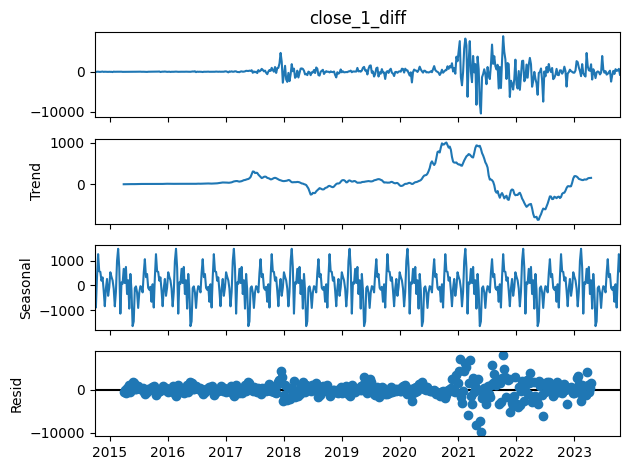

In [14]:
# Single differentiation wo box transformation - can be used for a simple ARIMA model.
df_week['close_1_diff'] = df_week.Close - df_week.Close.shift(1)
sm.tsa.seasonal_decompose(df_week.close_1_diff[1:], model="additive").plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_week.close_1_diff[1:])[1])
# the variance seems to be increasing here

Dickey–Fuller test: p=0.000000


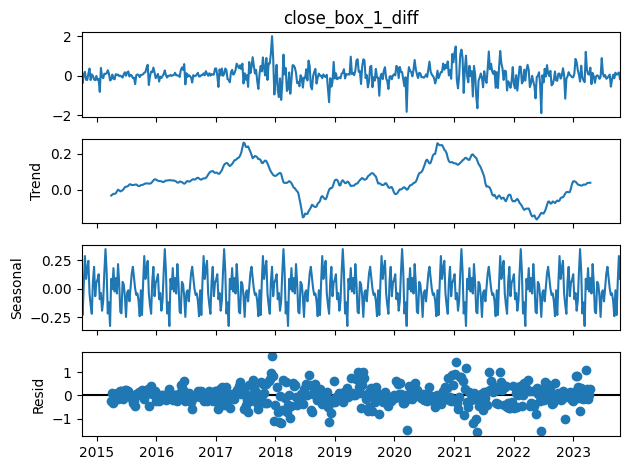

In [15]:
# Single differentiation - can be used for ARIMA model with box transformation.
df_week['close_box_1_diff'] = df_week.Close_box - df_week.Close_box.shift(1)
sm.tsa.seasonal_decompose(df_week.close_box_1_diff[1:], model="additive").plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_week.close_box_1_diff[1:])[1])
# no increasing variance here

Dickey–Fuller test: p=0.003767


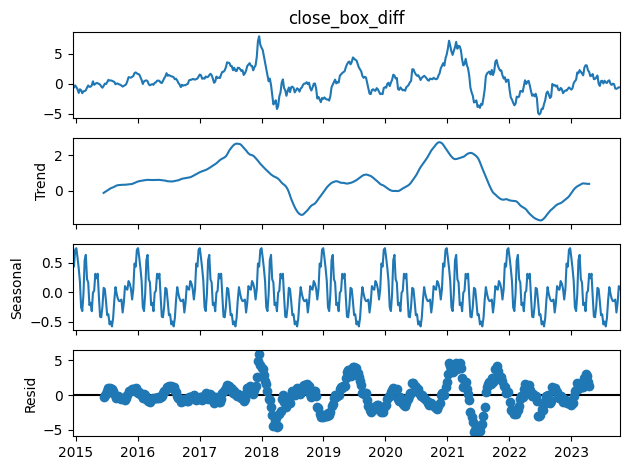

In [16]:
# Seasonal differentiation - can be used for SARIMA Model
df_week['close_box_diff'] = df_week.Close_box - df_week.Close_box.shift(12)
sm.tsa.seasonal_decompose(df_week.close_box_diff[12:], model="additive").plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_week.close_box_diff[12:])[1])

This is stationary

#### Computing the ACF and PACF - for the stationary time series

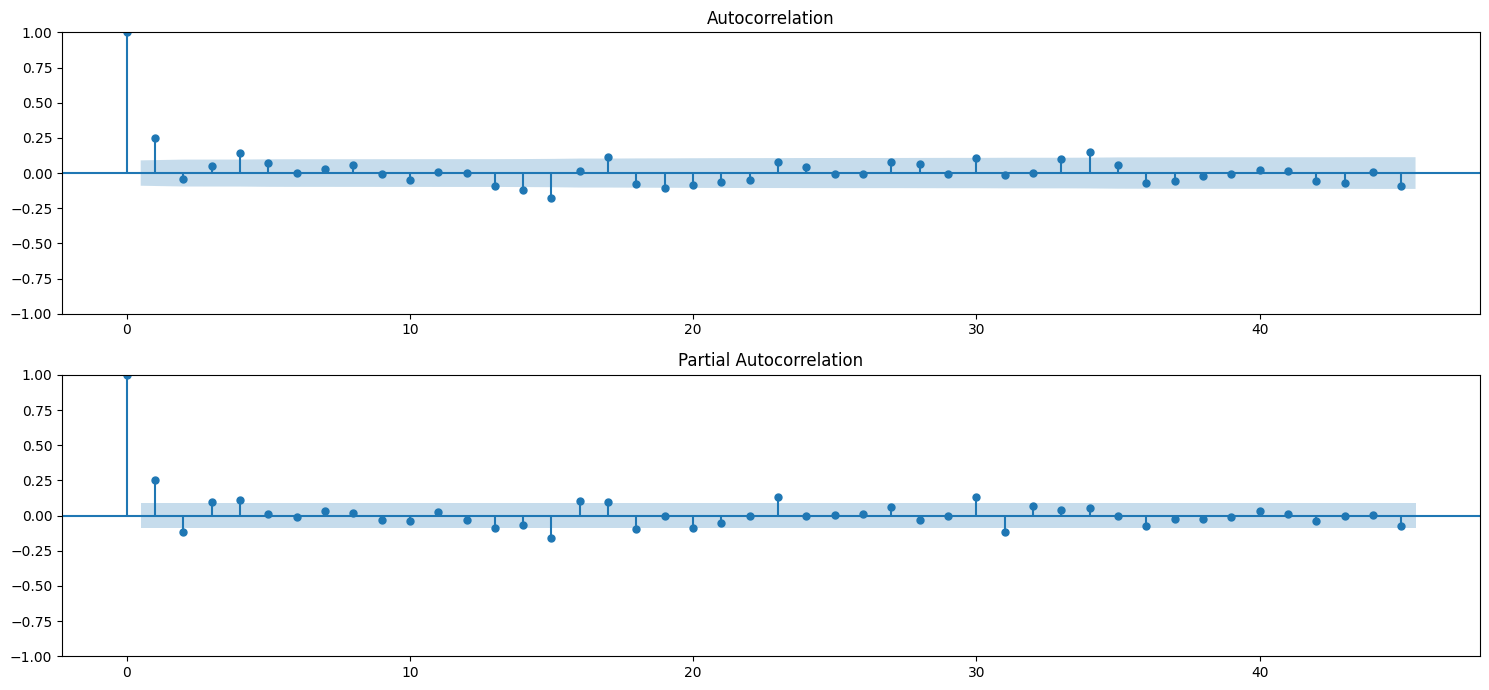

In [17]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_week.close_1_diff[1:].values.squeeze(), lags=45, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_week.close_1_diff[1:].values.squeeze(), lags=45, ax=ax)
plt.tight_layout()
plt.show()

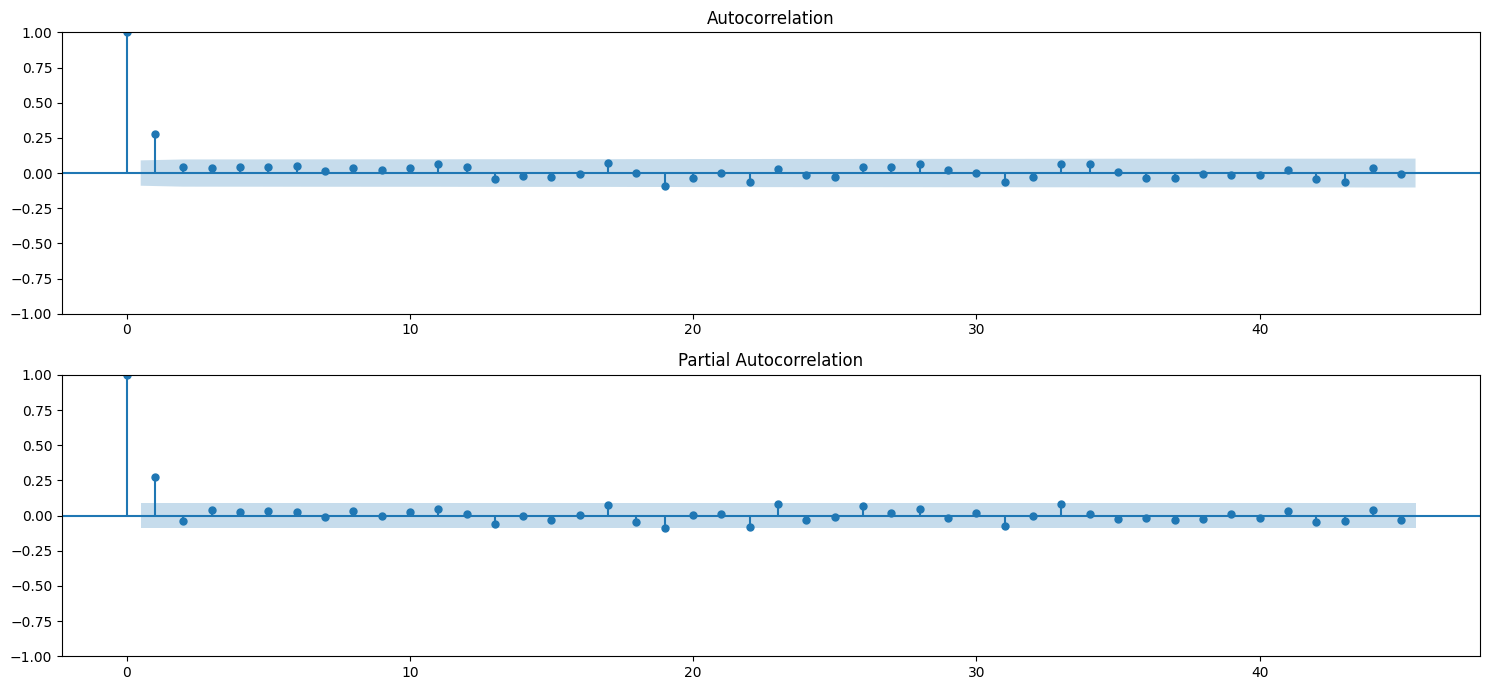

In [18]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots - best and simplest model?
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_week.close_box_1_diff[1:].values.squeeze(), lags=45, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_week.close_box_1_diff[1:].values.squeeze(), lags=45, ax=ax)
plt.tight_layout()
plt.show()

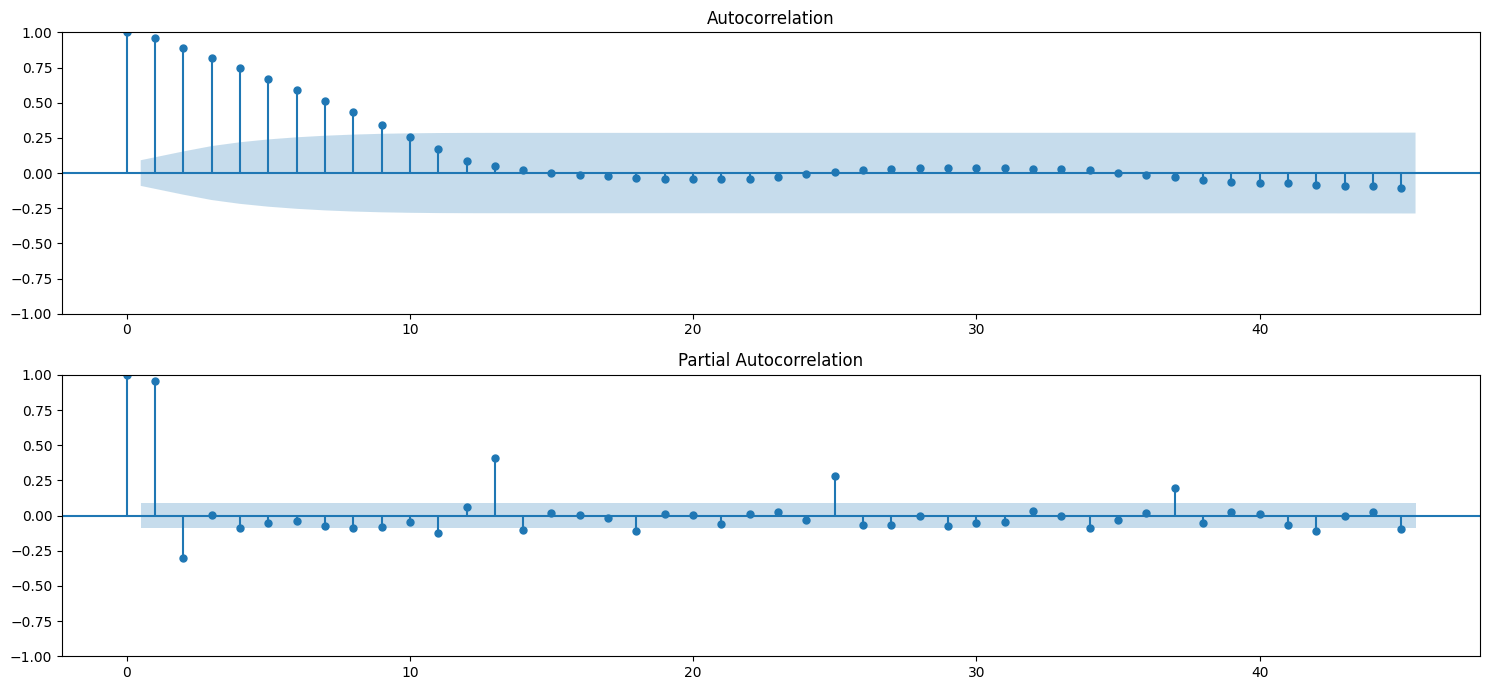

In [19]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_week.close_box_diff[12:].values.squeeze(), lags=45, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_week.close_box_diff[12:].values.squeeze(), lags=45, ax=ax)
plt.tight_layout()
plt.show()

In [40]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(df_week.close_box_1_diff[1:], lags=10)

,lb_stat,lb_pvalue
1,36.442337,1.572501e-09
2,37.212382,8.306804e-09
3,37.875429,3.003428e-08
4,38.774004,7.756849e-08
5,39.776008,1.657015e-07
6,40.839011,3.114984e-07
7,40.947519,8.285946e-07
8,41.595650,1.612592e-06
9,41.800526,3.574266e-06
10,42.336935,6.531065e-06


#### Modelling the series

In [21]:
# using the ARIMA Model on Untransformed Shift 1 data
ps = (0,1,2,3,4)
qs = (0,1,2,3,4)
d = 1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

results = []
best_aic = float("inf")
for param in parameters_list:
    try:
        arima_model=ARIMA(df_week.Close, order=(param[0], d, param[1]))
        model = arima_model.fit()
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model_1 = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model_1.summary())

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


   parameters          aic
20     (4, 0)  8375.839464
13     (2, 3)  8376.561406
16     (3, 1)  8377.255596
21     (4, 1)  8377.771987
17     (3, 2)  8378.408281
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  474
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -4182.920
Date:                Fri, 13 Oct 2023   AIC                           8375.839
Time:                        14:53:05   BIC                           8396.635
Sample:                    09-22-2014   HQIC                          8384.019
                         - 10-16-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2830      0.021     13.230     

The Ljung-Box test uses the following hypotheses:

H0: The residuals are independently distributed.

HA: The residuals are not independently distributed; they exhibit serial correlation.

Dickey–Fuller test:: p=0.000001
     lb_stat  lb_pvalue
1   0.001447   0.969659
2   0.002427   0.998787
3   0.003319   0.999949
4   0.039073   0.999812
5   0.192648   0.999191
6   0.192648   0.999861
7   0.323224   0.999871
8   0.749587   0.999390
9   0.752970   0.999827
10  1.537002   0.998815


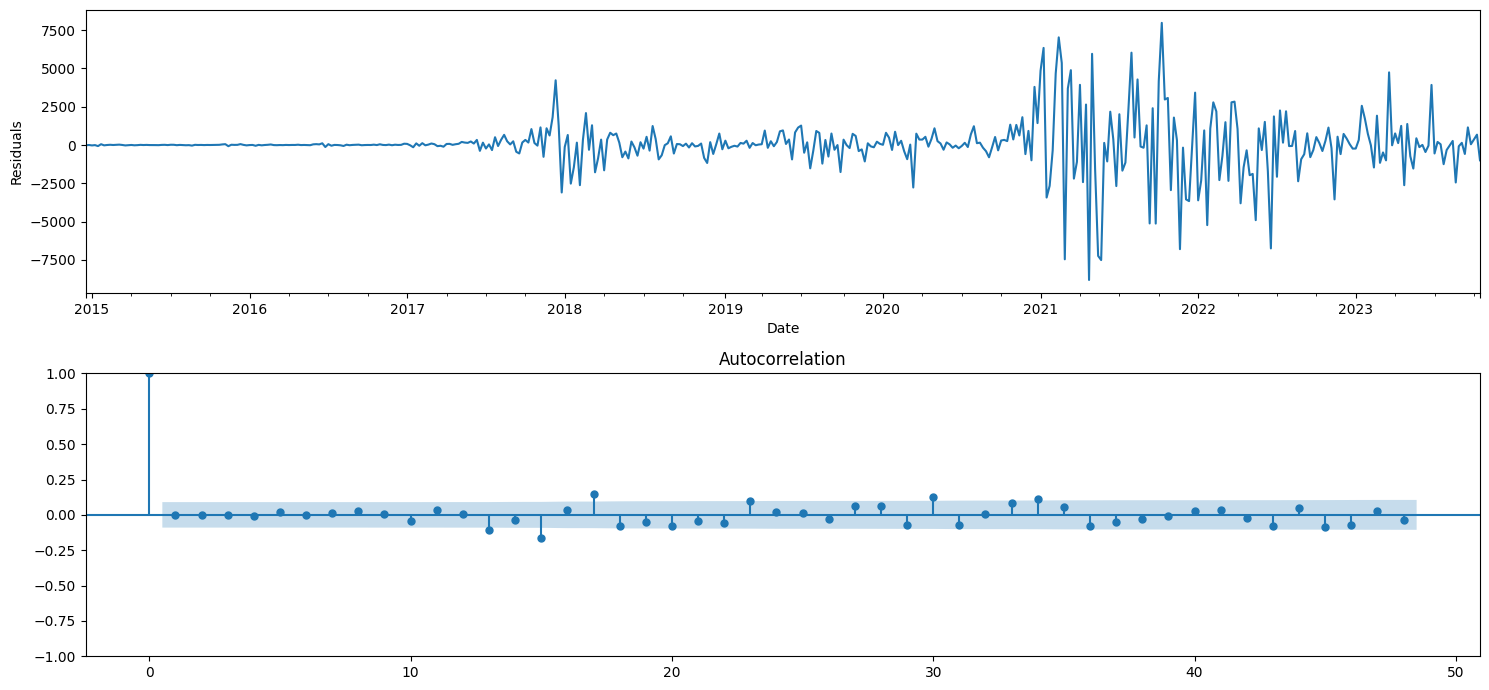

In [46]:
# STL-decomposition

plt.figure(figsize=(15,7))
plt.subplot(211)
best_model_1.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model_1.resid[1:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model_1.resid[1:])[1])
print(acorr_ljungbox(best_model_1.resid[1:], lags=10))

plt.tight_layout()
plt.show()

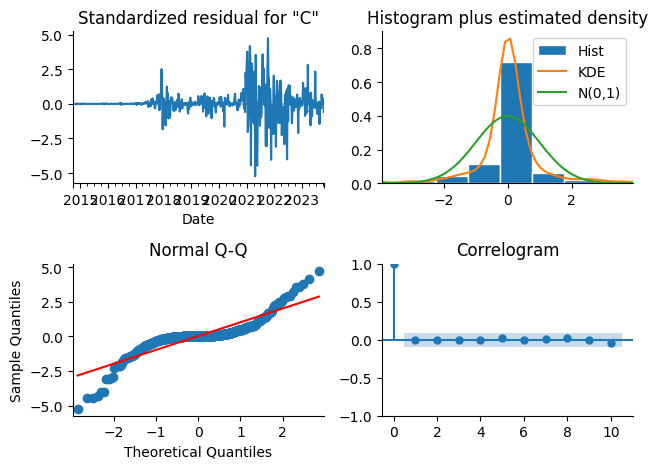

In [53]:
import seaborn as sns
best_model_1.plot_diagnostics()
sns.despine()
plt.tight_layout()

In [47]:
# using the ARIMA Model on Box-transformed Shift 1 data
ps = (0,1,2)
qs = (0,1,2)
d = 1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

results = []
best_aic = float("inf")
for param in parameters_list:
    try:
        arima_model=ARIMA(df_week.Close_box, order=(param[0], d, param[1]))
        model = arima_model.fit()
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model_2 = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model_2.summary())

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/homebrew/lib/python3.11/s

  parameters         aic
1     (0, 1)  528.860018
3     (1, 0)  529.000952
5     (1, 2)  529.834103
4     (1, 1)  530.236188
2     (0, 2)  530.346909
                               SARIMAX Results                                
Dep. Variable:              Close_box   No. Observations:                  474
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -262.430
Date:                Fri, 13 Oct 2023   AIC                            528.860
Time:                        16:38:01   BIC                            537.178
Sample:                    09-22-2014   HQIC                           532.132
                         - 10-16-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2851      0.038      7.562      0.000      

Dickey–Fuller test:: p=0.000000
     lb_stat  lb_pvalue
1   0.012297   0.911700
2   0.547385   0.760566
3   0.744677   0.862649
4   1.206659   0.877001
5   1.543652   0.907978
6   2.382569   0.881372
7   2.397753   0.934598
8   3.047912   0.931315
9   3.067672   0.961551
10  3.244296   0.975076


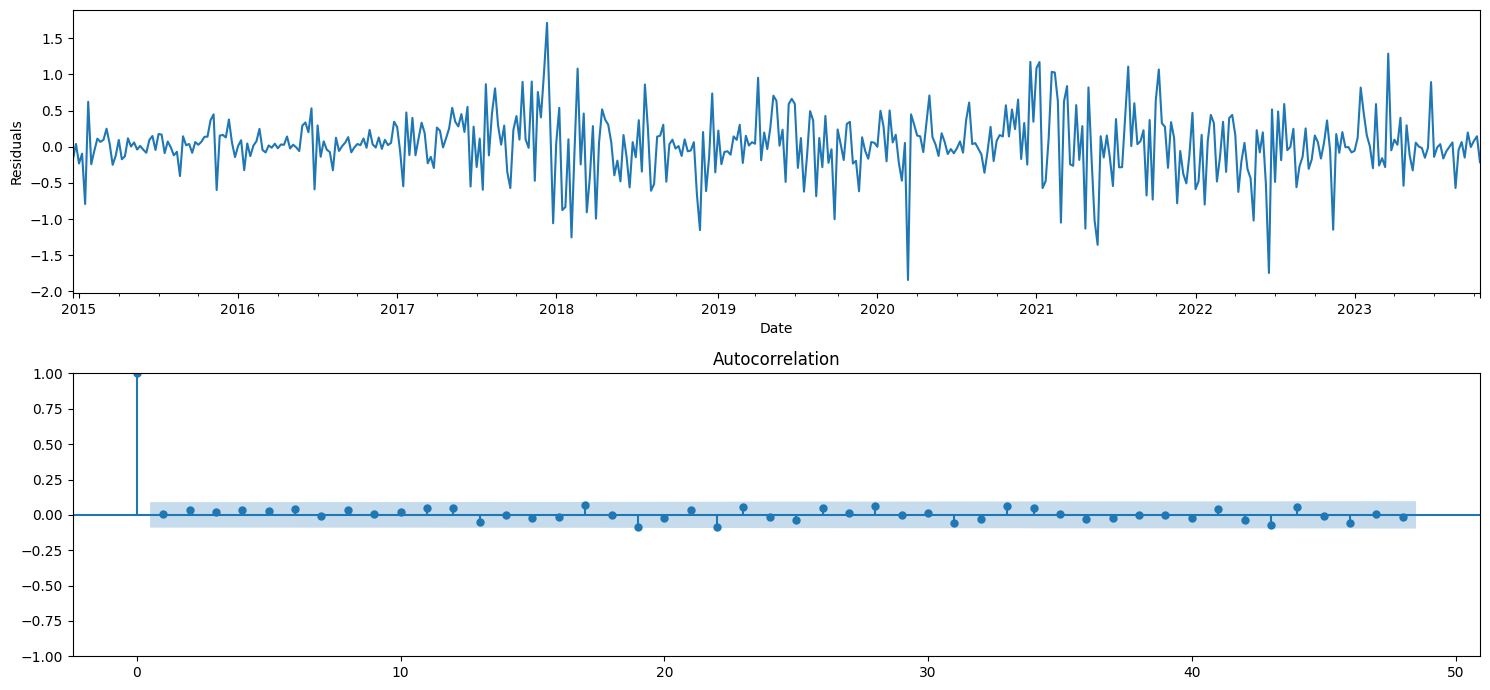

In [49]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model_2.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model_2.resid[1:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model_2.resid[1:])[1])
print(acorr_ljungbox(best_model_2.resid[1:],lags=10))

plt.tight_layout()
plt.show()

In [ ]:
# using the ARIMA Model on Box-transformed Seasonal Shift
ps = range(0,3)
qs = range(0,3)
d = 1
D = 1
Ps = range(0,3)
Qs = range(0,3)
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

results = []
best_aic = float("inf")
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_week.Close_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model_3 = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model_3.summary())

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximu

      parameters         aic
10  (0, 1, 0, 1)  565.518452
11  (0, 1, 0, 2)  565.884625
13  (0, 1, 1, 1)  565.895152
28  (1, 0, 0, 1)  566.199434
31  (1, 0, 1, 1)  566.604533
                                     SARIMAX Results                                      
Dep. Variable:                          Close_box   No. Observations:                  474
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -279.759
Date:                            Thu, 12 Oct 2023   AIC                            565.518
Time:                                    11:57:16   BIC                            577.919
Sample:                                09-22-2014   HQIC                           570.401
                                     - 10-16-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------

Dickey–Fuller test:: p=0.000000


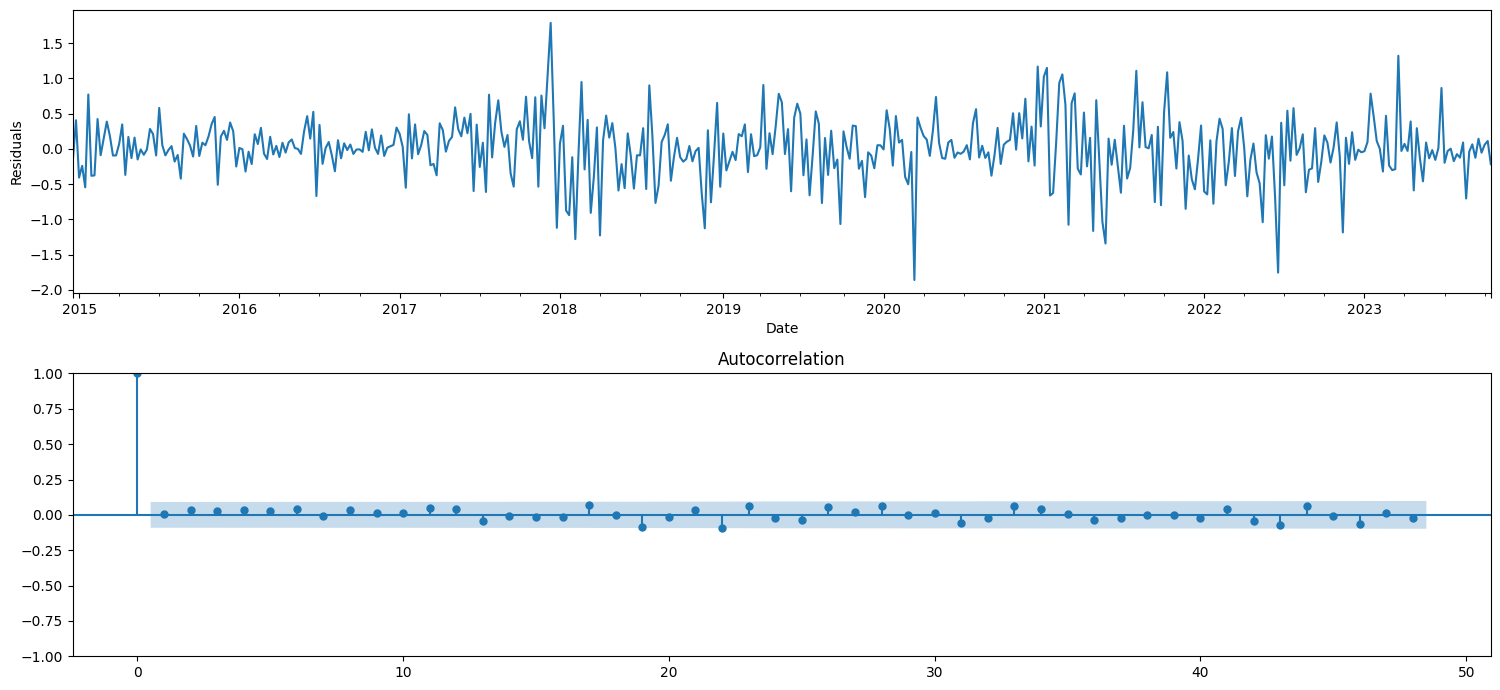

In [ ]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model_3.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model_3.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model_3.resid[13:])[1])

plt.tight_layout()
plt.show()

#### Model Forecasting

In [ ]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

/var/folders/2y/x00pyx115dl4rz225kttc1pw0000gn/T/ipykernel_67058/1050940299.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_week2['forecast'] = best_model_1.predict(start=0, end=df_week2.shape[0]+5)


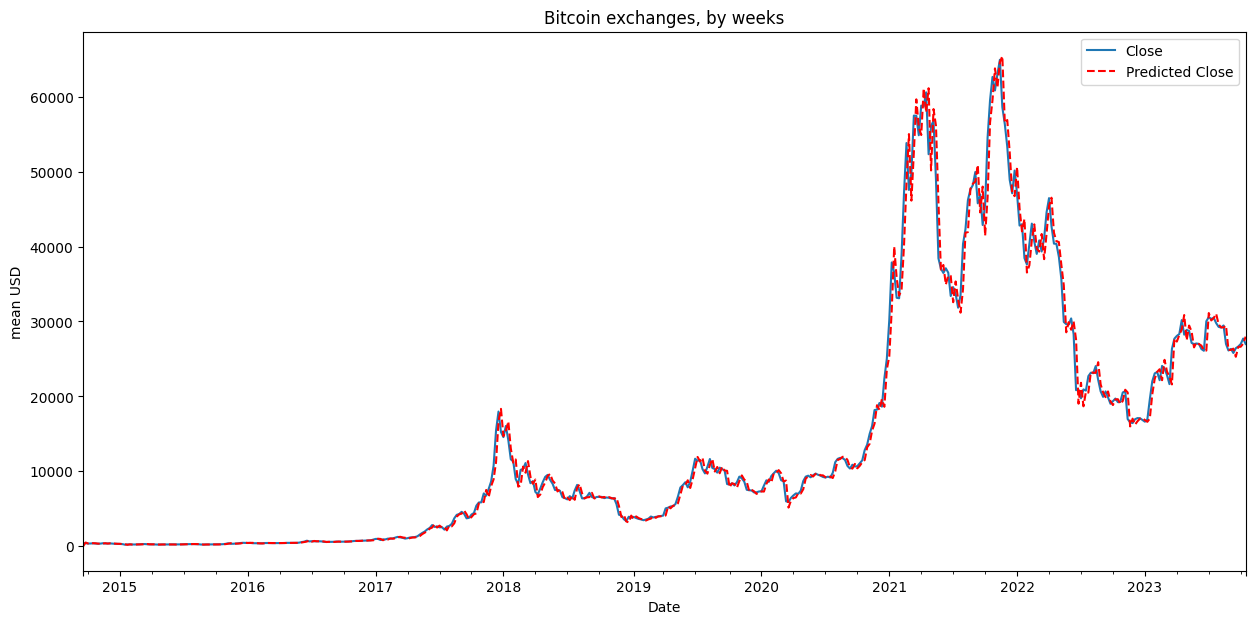

Root Mean Squared Error = 1674.584331870625
R2 Score = 0.9889555031763331


In [ ]:
# Prediction - best_model 1
df_week2 = df_week[['Close']]
df_week2['forecast'] = best_model_1.predict(start=0, end=df_week2.shape[0]+5)
plt.figure(figsize=(15,7))
df_week2.Close.plot()
df_week2.forecast.plot(color='r', ls='--', label='Predicted Close')
plt.legend()
plt.title('Bitcoin exchanges, by weeks')
plt.ylabel('mean USD')
plt.show()
print(f"Root Mean Squared Error = {sqrt(mean_squared_error(df_week2.Close, df_week2.forecast))}")
print(f"R2 Score = {r2_score(df_week2.Close, df_week2.forecast)}")

/var/folders/2y/x00pyx115dl4rz225kttc1pw0000gn/T/ipykernel_67058/2852232911.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_week3['forecast'] = invboxcox(best_model_2.predict(start=0, end=df_week3.shape[0]+5), lmbda)


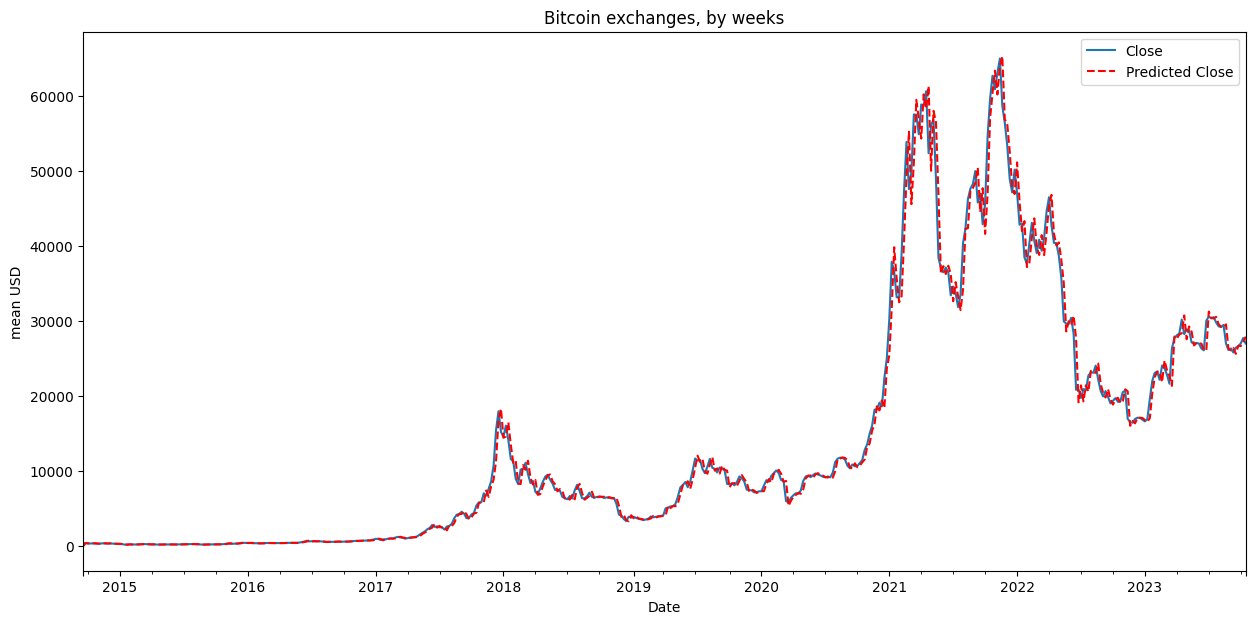

Root Mean Squared Error = 1687.335666714633
R2 Score = 0.9887866633438434


In [ ]:
# Prediction - best_model 2
df_week3 = df_week[['Close']]
df_week3['forecast'] = invboxcox(best_model_2.predict(start=0, end=df_week3.shape[0]+5), lmbda)
plt.figure(figsize=(15,7))
df_week3.Close.plot()
df_week3.forecast.plot(color='r', ls='--', label='Predicted Close')
plt.legend()
plt.title('Bitcoin exchanges, by weeks')
plt.ylabel('mean USD')
plt.show()
print(f"Root Mean Squared Error = {sqrt(mean_squared_error(df_week3.Close, df_week3.forecast))}")
print(f"R2 Score = {r2_score(df_week3.Close, df_week3.forecast)}")

/var/folders/2y/x00pyx115dl4rz225kttc1pw0000gn/T/ipykernel_67058/2897594715.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_week4['forecast'] = invboxcox(best_model_3.predict(start=0, end=df_week4.shape[0]+5), lmbda)


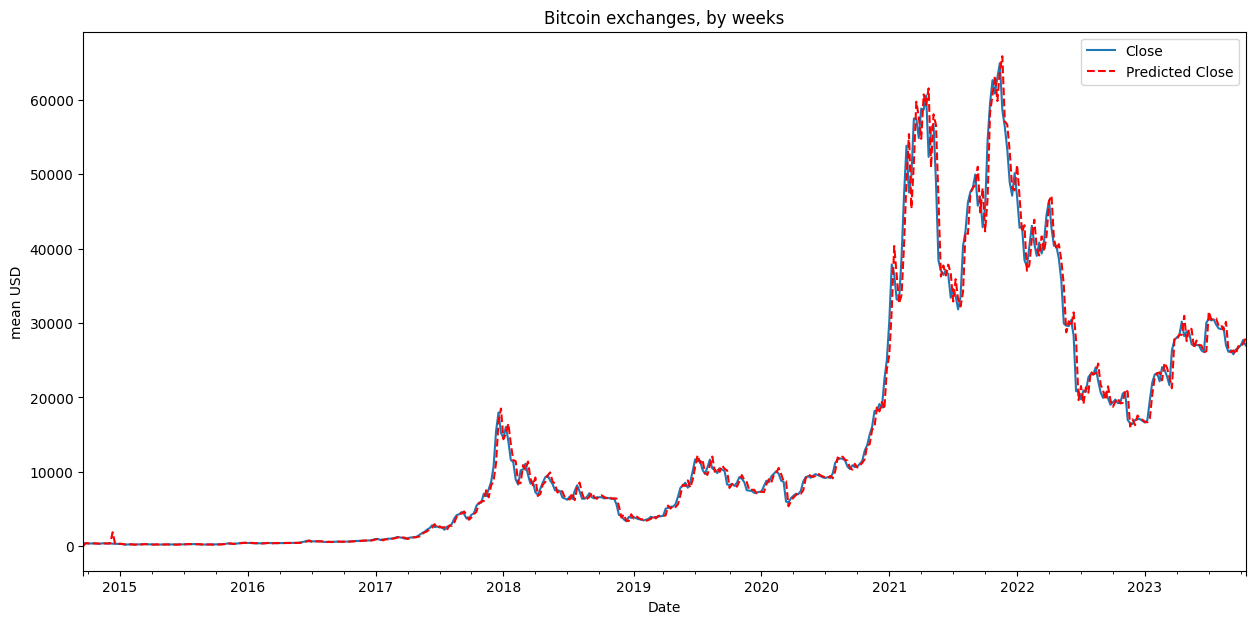

Root Mean Squared Error = 1715.1575651469052
R2 Score = 0.9884138289933403


In [ ]:
# Prediction - best_model 3
df_week4 = df_week[['Close']]
df_week4['forecast'] = invboxcox(best_model_3.predict(start=0, end=df_week4.shape[0]+5), lmbda)
plt.figure(figsize=(15,7))
df_week4.Close.plot()
df_week4.forecast.plot(color='r', ls='--', label='Predicted Close')
plt.legend()
plt.title('Bitcoin exchanges, by weeks')
plt.ylabel('mean USD')
plt.show()
print(f"Root Mean Squared Error = {sqrt(mean_squared_error(df_week4.Close, df_week4.forecast))}")
print(f"R2 Score = {r2_score(df_week4.Close, df_week4.forecast)}")

In [ ]:
ax = best_model.plot_predict('2023-10', '2024-3', dynamic=True, plot_insample=False, ax=ax);

NameError: name 'best_model' is not defined